## Data Understanding

Untuk memahami dataset berupa gambar, definisikan terlebih dahulu direktori datasetnya ke dalam sebuah variabel. Selanjutnya tiap kelas atau label yang tersedia dapat diketahui dengan memanggil os.listdir



In [24]:
# Mendefinisikan direktori utama dataset
#dataset ini upload terlebih dulu ke drive agar bisa di load di google colab,
#atau kalian bisa langsung download lewat kaggle langsung di google colab

import os
base_dir = '/content/drive/MyDrive/flowers'

In [25]:
print(os.listdir(base_dir))

['rose', 'dandelion', 'daisy', 'sunflower', 'tulip']


Untuk mengetahui jumlah file yang ada, dapat menggunakan fungsi len() pada tiap direktori label dan menjumlahkannya. Untuk memudahkan pembacaan data dapat juga divisualisasikan menggunakan bantuan library matplotlib.



In [26]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


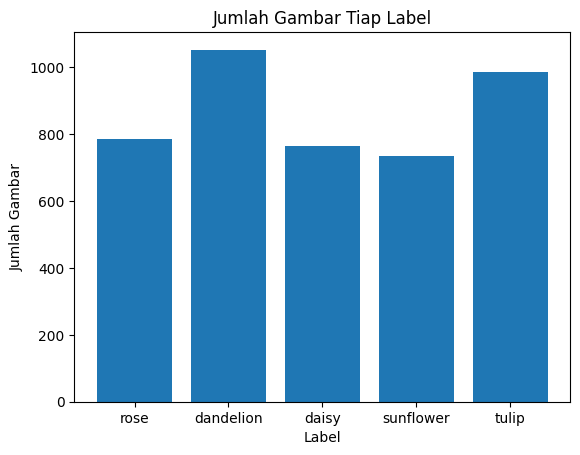

In [27]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

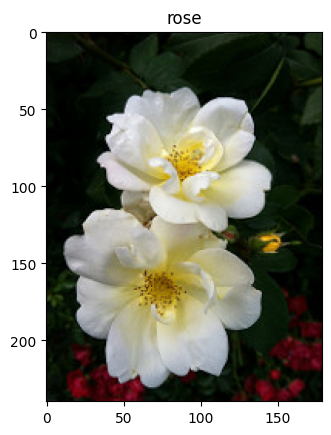

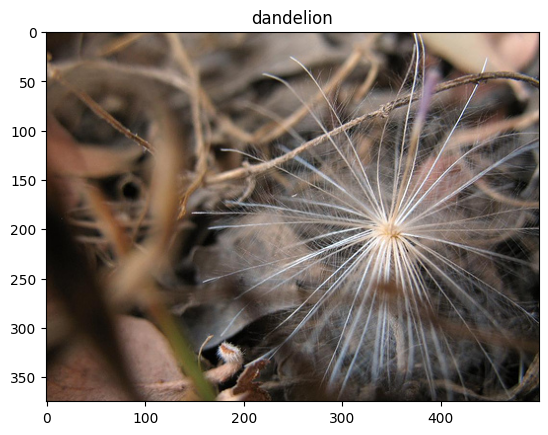

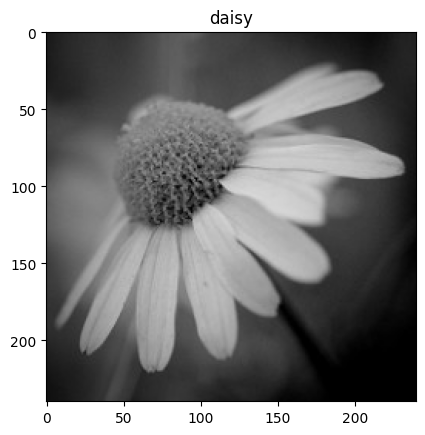

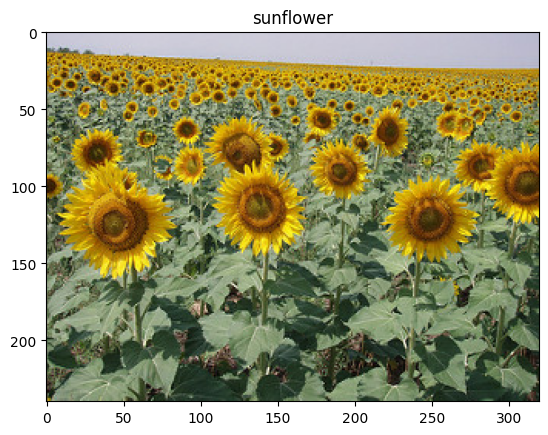

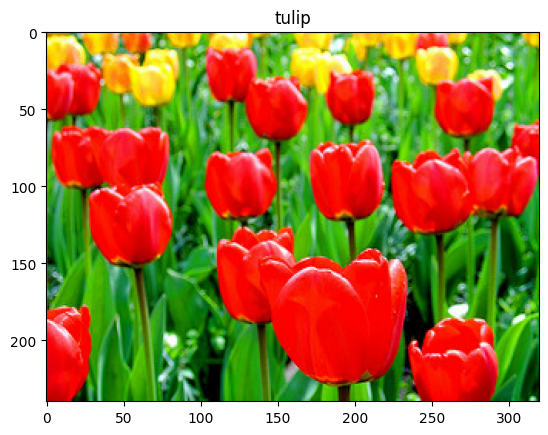

In [28]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

## Data Preparation

In [29]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [30]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [31]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [32]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

# Modelling

##Membuat Arsitektur CNN

Penyusunan Layer

In [33]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [34]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
109/109 [==============================] - 896s 8s/step - loss: 1.3189 - accuracy: 0.4119 - val_loss: 1.5611 - val_accuracy: 0.3965
Epoch 2/5
109/109 [==============================] - 402s 4s/step - loss: 1.1055 - accuracy: 0.5566 - val_loss: 1.0240 - val_accuracy: 0.5802
Epoch 3/5
109/109 [==============================] - 402s 4s/step - loss: 0.9641 - accuracy: 0.6231 - val_loss: 0.9940 - val_accuracy: 0.5895
Epoch 4/5
109/109 [==============================] - 378s 3s/step - loss: 0.9106 - accuracy: 0.6375 - val_loss: 1.0515 - val_accuracy: 0.6326
Epoch 5/5
109/109 [==============================] - 404s 4s/step - loss: 0.8466 - accuracy: 0.6723 - val_loss: 0.9157 - val_accuracy: 0.6628


Evaluasi Model CNN

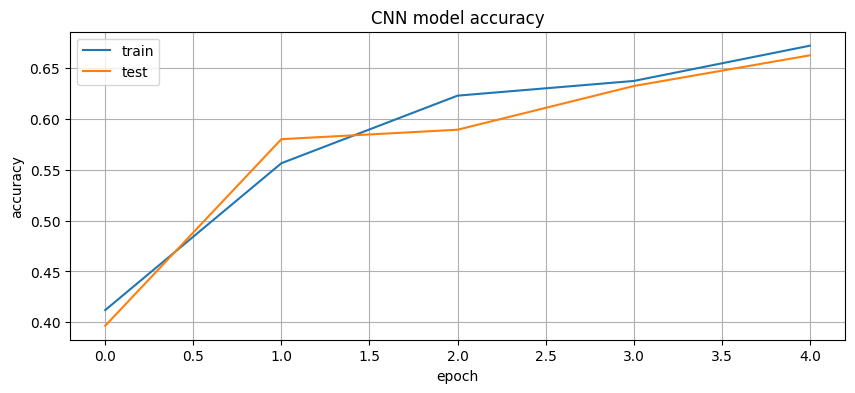

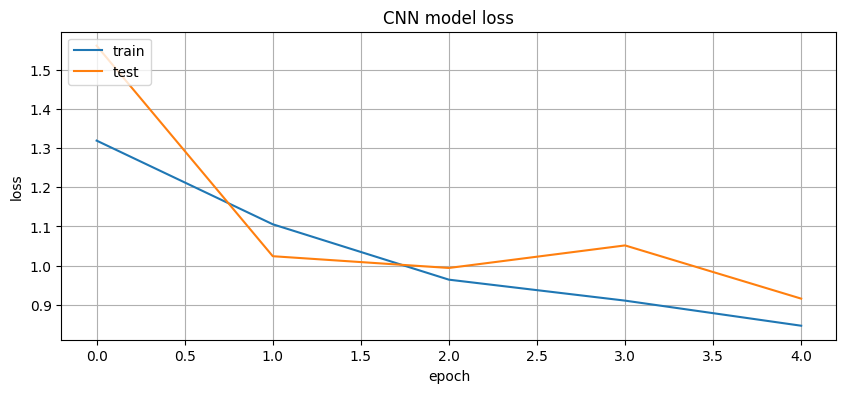

In [35]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan VGG16

Memuat Model VGG16

In [36]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 0s 0us/step


In [37]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [38]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
109/109 [==============================] - 2220s 20s/step - loss: 1.1121 - accuracy: 0.5649 - val_loss: 0.7095 - val_accuracy: 0.7302
Epoch 2/5
109/109 [==============================] - 2171s 20s/step - loss: 0.7672 - accuracy: 0.7102 - val_loss: 0.5784 - val_accuracy: 0.7988
Epoch 3/5
109/109 [==============================] - 2148s 20s/step - loss: 0.7155 - accuracy: 0.7452 - val_loss: 0.6052 - val_accuracy: 0.7779
Epoch 4/5
109/109 [==============================] - 2162s 20s/step - loss: 0.7127 - accuracy: 0.7399 - val_loss: 0.6180 - val_accuracy: 0.7674
Epoch 5/5
109/109 [==============================] - 2157s 20s/step - loss: 0.6131 - accuracy: 0.7706 - val_loss: 0.5575 - val_accuracy: 0.7884


Evaluasi Model

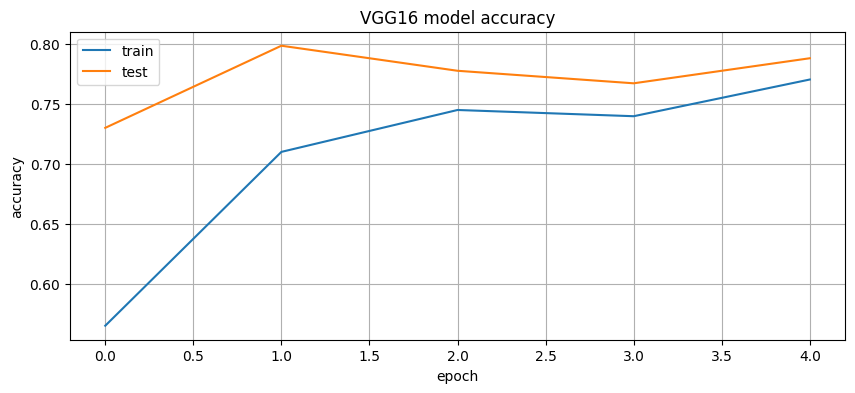

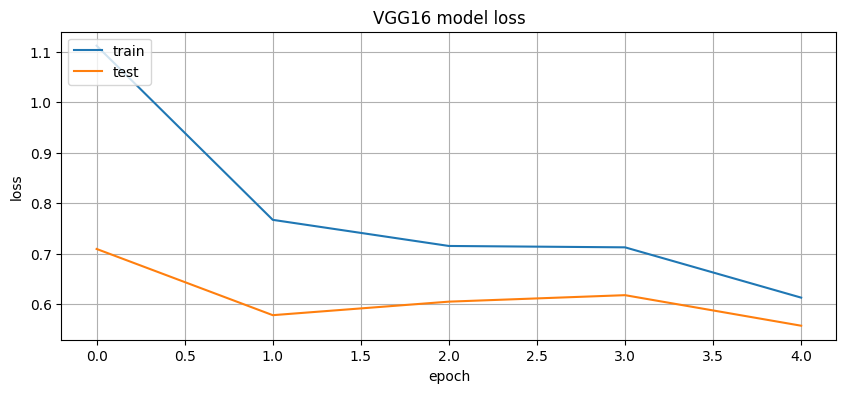

In [39]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan ResNet50

Memuat Model ResNet50

In [40]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

94765736/94765736 [==============================] - 0s 0us/step


In [41]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [44]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
109/109 [==============================] - 844s 8s/step - loss: 1.5833 - accuracy: 0.2939 - val_loss: 1.5527 - val_accuracy: 0.2860
Epoch 2/5
109/109 [==============================] - 815s 7s/step - loss: 1.5515 - accuracy: 0.3150 - val_loss: 1.4648 - val_accuracy: 0.3849
Epoch 3/5
109/109 [==============================] - 754s 7s/step - loss: 1.5309 - accuracy: 0.3338 - val_loss: 1.4328 - val_accuracy: 0.4070
Epoch 4/5
109/109 [==============================] - 817s 8s/step - loss: 1.5183 - accuracy: 0.3465 - val_loss: 1.4347 - val_accuracy: 0.3977
Epoch 5/5
109/109 [==============================] - 746s 7s/step - loss: 1.4867 - accuracy: 0.3558 - val_loss: 1.4045 - val_accuracy: 0.4267


Evaluasi Model

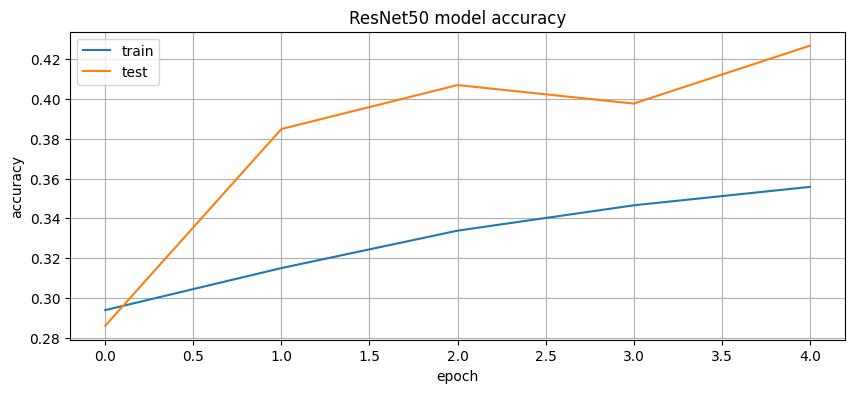

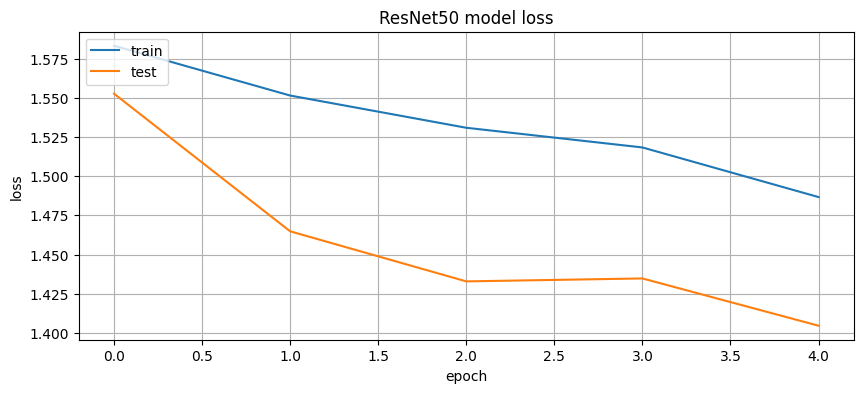

In [45]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan DenseNet201

Memuat Model DenseNet201

In [46]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 0s 0us/step


In [47]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Evaluasi Model

In [48]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

NameError: ignored

<Figure size 1000x400 with 0 Axes>

#Evaluation

Setelah membuat beberapa model, maka dapat kita bandingkan akurasi dari model-model tersebut dengan visualisasi berikut ini.



In [ ]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

Dari hasil tersebut dapat diketahui bahwa model dengan DenseNet201 memiliki kinerja yang lebih baik. Untuk itu model tersebut yang akan dipilih untuk digunakan.

# Uji Coba Model

Setelah mendapatkan model dengan kinerja yang baik, maka dapat diujicobakan untuk mengenali gambar bunga.



In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

In [ ]:
# Menguji coba model
import numpy as np
from keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')

# Deployment

Agar nantinya dapat diimplementasikan atau dikembangkan lebih lanjut, model perlu dilakukan deploy terlebih dahulu dalam format HDF5, TFLite (Mobile) atau TensorflowJS (Web)

HDF5

In [ ]:
densenet_model.save('model-flowers-recognition.h5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

TensorflowJS

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs

# Penutup

Saat ini model machine learning untuk mengenali gambar bunga telah didapatkan. Dengan model ini dapat diimplementasikan lebih lanjut menjadi aplikasi web atau mobile untuk mengenali jenis bunga. Namun tentu saja model ini juga masih dapat disempurnakan dengan mencoba pretrained model yang lain, melakukan fine-tuning, atau dengan mengubah dataset yang lebih beragam dan berkualitas.